In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

%matplotlib inline

## Set some values globally
# Ticks label size
label_size = 10
mpl.rcParams['xtick.labelsize'] = label_size     
mpl.rcParams['ytick.labelsize'] = label_size
# Ticks width
ticks_width = 0.5
mpl.rcParams['xtick.major.width'] = ticks_width
mpl.rcParams['ytick.major.width'] = ticks_width
# Line width
mpl.rcParams['axes.linewidth'] = 0.5

### 2D quared-lattice Ising Hamiltonian:
\begin{equation}
H = -J \sum_{\langle i, j \rangle} S^z_i S^z_j
\end{equation}

In [2]:
def plot_configuration(spins):
    '''
    Helper function to plot the configuration of spins given by `spins`.
    
    Arguments: 
        spins -- a spin configuration; type: numpy array of shape (N, N).
    '''
    
    N = np.shape(spins)[1]
    
    fig, ax = plt.subplots(dpi=100, figsize=(5, 5))
    fig.add_axes()
    ax = fig.axes[0]
    
    # Plot spins (circles).
    colors = ['C0', 'C1']   # blue: down, orange: up.

    for i in range(N):
        for j in range(N):
            fig.gca().add_patch(plt.Circle((i,j), radius=0.35, fc=colors[int((spins[i, j]+1)/2.)], 
                                           ec='k', lw=0.3))
    
    # Plot lattice (grid).
    for i in range(N):
        ax.plot([i, i], [0, N-1], 'k', lw=0.5)
        ax.plot([0, N-1], [i, i], 'k', lw=0.5)

    ax.set_ylim(-1, N+1)
    ax.set_xlim(-1, N+1)
    ax.set_aspect('equal')
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('off')
    plt.savefig('ising.png', bbox_inches='tight', dpi=600)
#     fig.show()

In [14]:
# size of the system NxN
N = 30

First we need to create training and test configurations with the script **create_configurations.py**, then run the next cells.

In [15]:
# Training set.
train_configs = np.loadtxt("configs/train_configs_30x30.txt")
train_labels = np.loadtxt("configs/train_labels_30x30.txt")
print("Loaded %i training configurations of size %ix%i for training."%(len(train_configs), N, N))

Loaded 2550 training configurations of size 30x30 for training.


In [16]:
# Test set.
test_configs = np.array(np.loadtxt("configs/test_configs_30x30.txt"))
test_labels = np.array(np.loadtxt("configs/test_labels_30x30.txt"))
print("Loaded %i test configurations of size %ix%i for testing."%(len(test_configs), N,N))

Loaded 550 test configurations of size 30x30 for testing.


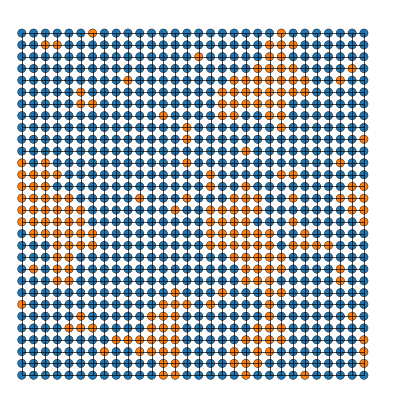

In [12]:
# Just diplay one configuration.
plot_configuration(np.reshape(np.array(train_configs[1340]), (N, N)))

In [13]:
def pca(X=np.array([]), no_dims=2):
    """
    Runs PCA on the NxD array X to reduce dimension.
    """
    
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

In [14]:
PCA_coord = pca(train_configs, no_dims=2)

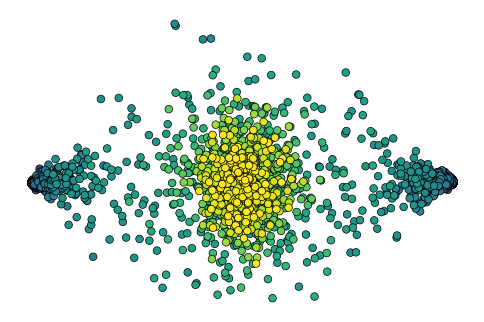

In [15]:
fig = plt.figure(dpi=100)

plt.scatter(PCA_coord[:, 0], PCA_coord[:, 1], 30, train_labels,
            marker='o', edgecolors='k', linewidths=0.5)

plt.axis('off')
plt.show()

## Small dense network

In [17]:
# Prepare data for training;
# exclude temperatures between 2.1 and 2.4.

T_low = 2.1
T_high = 2.4

x = []
y = []

for i, label in enumerate(train_labels):
    if label < T_low:
        x.append(train_configs[i])
        y.append((1, 0))   # Low-T
    if label > T_high:
        x.append(train_configs[i])
        y.append((0, 1))   # High-T
        
x = np.array(x)
y = np.array(y)

In [18]:
# Create model.
# Network architecture: input layer, hidden layer with 3 neurons, and output layer with 2 neurons.
model = Sequential()
model.add(Dense(3, input_dim=N**2, kernel_initializer='glorot_normal', activation='sigmoid', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, kernel_initializer='glorot_normal', activation='softmax', 
                kernel_regularizer=regularizers.l2(0.0)))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 2703      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8         
Total params: 2,711
Trainable params: 2,711
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Train model.
model.fit(x, y, epochs=25, batch_size=32)

Epoch 1/25
2200/2200 [==============================] - 0s 112us/step - loss: 0.8014 - accuracy: 0.5668
Epoch 2/25
2200/2200 [==============================] - 0s 52us/step - loss: 0.7177 - accuracy: 0.6436
Epoch 3/25
2200/2200 [==============================] - 0s 47us/step - loss: 0.6806 - accuracy: 0.5732
Epoch 4/25
2200/2200 [==============================] - 0s 50us/step - loss: 0.6478 - accuracy: 0.6273
Epoch 5/25
2200/2200 [==============================] - 0s 55us/step - loss: 0.6243 - accuracy: 0.6555
Epoch 6/25
2200/2200 [==============================] - 0s 52us/step - loss: 0.6020 - accuracy: 0.6741
Epoch 7/25
2200/2200 [==============================] - 0s 65us/step - loss: 0.5807 - accuracy: 0.6845
Epoch 8/25
2200/2200 [==============================] - 0s 70us/step - loss: 0.5596 - accuracy: 0.6982
Epoch 9/25
2200/2200 [==============================] - 0s 68us/step - loss: 0.5376 - accuracy: 0.8609
Epoch 10/25
2200/2200 [==============================] - 0s 65us/step - 

In [21]:
# Prepare data for testing;
# exclude temperatures between 2.1 and 2.4.

T_low = 2.1
T_high = 2.4

x_test = []
y_test = []

for i, label in enumerate(test_labels):
    if label < T_low:
        x_test.append(test_configs[i])
        y_test.append((1, 0))   # Low-T
    if label > T_high:
        x_test.append(test_configs[i])
        y_test.append((0, 1))   # High-T
        
x_test = np.array(x_test)
y_test = np.array(y_test)

In [22]:
# Evaluate model.
predictions = model.predict(test_configs)
preds = model.evaluate(x=x_test, y=y_test)

print ("Loss = {0:.3f}".format(preds[0]))
print ("Test Accuracy = {0:.3f}".format(preds[1]))

500/500 [==============================] - 0s 71us/step
Loss = 0.390
Test Accuracy = 0.898


In [23]:
Temps = list(np.sort(list(set(test_labels))))   # Unique temperatures
NT = len(Temps)

phase1 = np.zeros(NT)
phase2 = np.zeros(NT)
points = np.zeros(NT)

m = np.zeros(NT)   # Magnetization
lastT = 0.

for i, T in enumerate(test_labels):
    j = Temps.index(T)
    phase1[j] += predictions[i:i+1, 0][0]
    phase2[j] += predictions[i:i+1, 1][0]
    m[j] += abs(np.mean(test_configs[i]))
    points[j] += 1.

for j in range(NT):
    phase1[j] /= points[j]
    phase2[j] /= points[j]
    m[j] /= points[j]

The NN learns representations of the low- and high-temperature Ising states (see Fig. below).

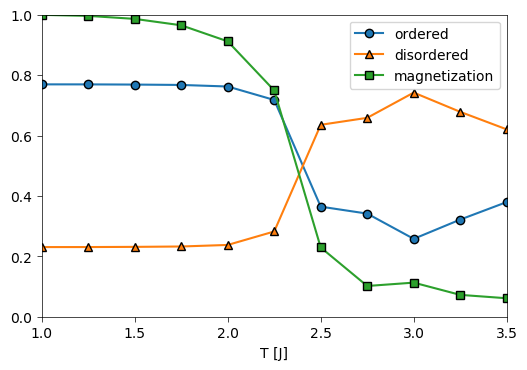

In [24]:
fig = plt.figure(dpi=100)

plt.plot(Temps, phase1, marker='o', markeredgecolor='k', label='ordered')
plt.plot(Temps, phase2, marker='^', markeredgecolor='k', label='disordered')
plt.plot(Temps, m, marker='s', markeredgecolor='k', label='magnetization')

plt.xlim(1, 3.5)
plt.xlabel('T [J]', )
plt.ylim(0, 1)

plt.legend()
# plt.show()
plt.savefig("ising_small_NN.png", bbox_inches='tight', dpi=600)

## Larger dense network

In [25]:
# Create bigger model.
# Network architecture: input layer, hidden layer with 32 neurons, and output layer with 2 neurons.

model2 = Sequential()
model2.add(Dense(32, input_dim=N**2, kernel_initializer='glorot_normal', activation='sigmoid', 
                 kernel_regularizer=regularizers.l2(0.02)))
model2.add(Dense(2, kernel_initializer='glorot_normal', activation='softmax',
                 kernel_regularizer=regularizers.l2(0.01)))

# Compile model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
# Train model.
model2.fit(x, y, epochs=25, batch_size=32)

Epoch 1/25
2200/2200 [==============================] - 0s 91us/step - loss: 1.5928 - accuracy: 0.4886
Epoch 2/25
2200/2200 [==============================] - 0s 58us/step - loss: 0.9532 - accuracy: 0.6155
Epoch 3/25
2200/2200 [==============================] - 0s 70us/step - loss: 0.7589 - accuracy: 0.7659
Epoch 4/25
2200/2200 [==============================] - 0s 79us/step - loss: 0.6706 - accuracy: 0.8391
Epoch 5/25
2200/2200 [==============================] - 0s 87us/step - loss: 0.6238 - accuracy: 0.8605
Epoch 6/25
2200/2200 [==============================] - 0s 90us/step - loss: 0.5811 - accuracy: 0.9218
Epoch 7/25
2200/2200 [==============================] - 0s 69us/step - loss: 0.5415 - accuracy: 0.9286
Epoch 8/25
2200/2200 [==============================] - 0s 71us/step - loss: 0.5049 - accuracy: 0.9386
Epoch 9/25
2200/2200 [==============================] - 0s 67us/step - loss: 0.4635 - accuracy: 0.9605
Epoch 10/25
2200/2200 [==============================] - 0s 75us/step - l

In [27]:
# Evaluate model.
predictions2 = model2.predict(test_configs)
preds2 = model2.evaluate(x=x_test, y=y_test)

print ("Loss = {0:.3f}".format(preds2[0]))
print ("Test Accuracy = {0:.3f}".format(preds2[1]))

500/500 [==============================] - 0s 76us/step
Loss = 0.203
Test Accuracy = 0.992


In [28]:
Temps = list(np.sort(list(set(test_labels))))   # Unique temperatures
NT = len(Temps)

phase1_2 = np.zeros(NT)
phase2_2 = np.zeros(NT)
points = np.zeros(NT)

m = np.zeros(NT)   # Magnetization
lastT = 0.

for i, T in enumerate(test_labels):
    j = Temps.index(T)
    phase1_2[j] += predictions2[i:i+1, 0][0]
    phase2_2[j] += predictions2[i:i+1, 1][0]
    m[j] += abs(np.mean(test_configs[i]))
    points[j] += 1.

for j in range(NT):
    phase1_2[j] /= points[j]
    phase2_2[j] /= points[j]
    m[j] /= points[j]

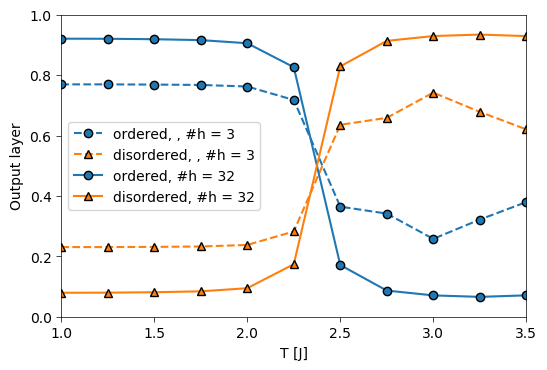

In [29]:
fig = plt.figure(dpi=100)

# Small network
plt.plot(Temps, phase1, ls='--', marker='o', markeredgecolor='k', label='ordered, , #h = 3')
plt.plot(Temps, phase2, ls='--', marker='^', markeredgecolor='k', label='disordered, , #h = 3')

# Bigger network
plt.plot(Temps, phase1_2, c='C0', marker='o', markeredgecolor='k', label='ordered, #h = 32')
plt.plot(Temps, phase2_2, c='C1', marker='^', markeredgecolor='k', label='disordered, #h = 32')

plt.xlim(1, 3.5)
plt.xlabel('T [J]')

plt.ylim(0, 1)
plt.ylabel('Output layer')

plt.legend()
# plt.show()
plt.savefig("ising_large_NN.png", bbox_inches='tight', dpi=600)

Analytical critical temperature (thermodynamic limit): $T_c = 2/\ln(1 + \sqrt{2}) \approx 2.269$.